# **Paquetes**

In [1]:
%%capture
# Paquete de Python que facilita la manipulación de datos terrestres
!pip install earthpy

# Librería Basemap
# !pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1" "basemap-data-hires == 1.3.0b1"

# Raster managing package installing
!pip install rioxarray

# Basemap tiles package
!pip3 install contextily

# Auxiliary functions for geopandas
!pip install rtree

# Function to extract zip files
import zipfile

In [2]:
# Se importan funciones auxiliares desde GitHub requeridas para el desarrollo de
# este práctico
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 4.80 KiB | 4.80 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
import os                          # directory managing
from glob import glob              # files managing
import contextily as cx            # basemap tiles
import geopandas as gpd            # shapefile managing
import matplotlib.colors as colors # customize colors
import matplotlib.pyplot as plt    # plots
import matplotlib.font_manager as fm # cutom fonts
import numpy as np                 # array managing
import pandas as pd                # structured data managing
import xarray as xr                # labelled multi-dimensional arrays
import rasterio as rio             # rastewr managing
import rioxarray as rxr            # raster managing
import seaborn as sns              # plots
from geopandas import GeoDataFrame
from matplotlib.colors import ListedColormap
from natsort import natsorted      # natural sorting strings
from urllib.request import urlopen # requests managing
from io import BytesIO             # file managing
from pandas import DataFrame       # pandas dataframe structure
from rasterio.plot import show     # plotting from rasterio
from matplotlib import colors, patches
from shapely.geometry import mapping, Point, Polygon # for clipping rasters using shapes and geometries managing
from shapely import geometry       # geomtric operations and managing
from tqdm import tqdm              # Progress tracking
from urllib.error import HTTPError # Error handler
from warnings import simplefilter  # get rid off warnings
from weather_data_preprocessing import null_report
from zipfile import ZipFile        # .zip files managing


# ML STAGE PACKAGES
from lightgbm import LGBMClassifier
from sklearn import model_selection

from sklearn.preprocessing import OneHotEncoder # to encode categotrical data
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

# **Importación de Datos**

In [4]:
# Para cargarlos desde un .zip
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Para subir archivos
#from google.colab import files
#uploaded = files.upload()

In [5]:
!unzip /content/drive/MyDrive/Agustina_Tesis/Rana_Toro/bullfrog_data.zip

Archive:  /content/drive/MyDrive/Agustina_Tesis/Rana_Toro/bullfrog_data.zip
  inflating: acegua-2007.tif         
  inflating: acegua-2012.tif         
  inflating: acegua-2017.tif         
  inflating: acegua-2022.tif         
 extracting: Charcos_2007.cpg        
  inflating: Charcos_2007.dbf        
  inflating: Charcos_2007.prj        
  inflating: Charcos_2007.sbn        
  inflating: Charcos_2007.sbx        
  inflating: Charcos_2007.shp        
  inflating: Charcos_2007.shp.xml    
  inflating: Charcos_2007.shx        
 extracting: Charcos_2012.cpg        
  inflating: Charcos_2012.dbf        
  inflating: Charcos_2012.prj        
  inflating: Charcos_2012.sbn        
  inflating: Charcos_2012.sbx        
  inflating: Charcos_2012.shp        
  inflating: Charcos_2012.shp.xml    
  inflating: Charcos_2012.shx        
 extracting: Charcos_2017.cpg        
  inflating: Charcos_2017.dbf        
  inflating: Charcos_2017.prj        
  inflating: Charcos_2017.sbn        
  inflating:

# **Funciones**

In [6]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

# **Main**

## Preprocesamiento de Datos

In [7]:
# Shape loadings
lst_charcos = glob(os.path.join(os.getcwd(),"*Charcos_*.shp"))
lst_charcos.sort()
charcos_acegua = [gpd.read_file(i) for i in lst_charcos]

In [8]:
# Raster loading
lst_rasters = glob(os.path.join(os.getcwd(),"*acegua-*.tif"))
lst_rasters.sort()

# For visualization purposes
raster_vis = [rxr.open_rasterio(i, masked = True).squeeze() for i in lst_rasters]
# For operative purposes
raster_op = [rio.open(i) for i in lst_rasters]

In [9]:
# Renaming label columns
charcos_acegua[0].rename(columns={"Inv_2007": "2007"}, inplace = True)
charcos_acegua[1].rename(columns={"Inv_2012": "2012"}, inplace = True)
charcos_acegua[2].rename(columns={"Inv_2017": "2017"}, inplace = True)
charcos_acegua[3].rename(columns={"Inv_2022": "2022"}, inplace = True)

In [10]:
# Year list
y = ['2007','2012','2017','2022']
df_charcos_acegua_us = charcos_acegua[0]

for i in range(1,len(charcos_acegua)):
    df_charcos_acegua_us = df_charcos_acegua_us.sjoin(
        # Left GeoDataFrame
        charcos_acegua[i],
        # Right GeoDataFrames got more locations
        how="right",
        # We are looking for intersections
        predicate='intersects',
        # Identifier for variables from first GeoDataFrame
        lsuffix = y[i-1],
        # Identifier for variables from second GeoDataFrame
        rsuffix = y[i])

# Retrieving the variables
df_charcos_acegua_us = df_charcos_acegua_us[['TIPO_OBJET_2022',
                                             'Charco_2022',
                                             'x_coord_2022',
                                             'y_coord_2022',
                                             '2007',
                                             '2012',
                                             '2017',
                                             '2022',
                                             'Abundancia_2007',
                                             'Abundancia_2012',
                                             'Abundancia_2017',
                                             'Abundancia_2022',
                                             'geometry']]

# Renaming columns
df_charcos_acegua_us.rename(columns={'TIPO_OBJET_2022':'TIPO_OBJET',
                                     'Charco_2022':'Charco',
                                     'x_coord_2022':'x_coord',
                                     'y_coord_2022':'y_coord',
                                     '2007':'Inv_2007',
                                     '2012':'Inv_2012',
                                     '2017':'Inv_2017',
                                     '2022':'Inv_2022'}, inplace =True)

In [11]:
# CRS raster checking
with rio.open(lst_rasters[0]) as src:
    raster_crs = src.crs
raster_crs

CRS.from_epsg(4326)

In [12]:
# Reprojecting
df_charcos_acegua_us = df_charcos_acegua_us.to_crs(raster_crs)

In [13]:
# Data sampling from rasters to shapes
y = ['2007','2012','2017','2022']

for i in range(0,len(y)):
    coord_list = [(x, y) for x, y in zip(df_charcos_acegua_us["geometry"].x,
                                         df_charcos_acegua_us["geometry"].y)]
    df_charcos_acegua_us["LULC_val"+"_"+y[i]] = [x for x in raster_op[i].sample(coord_list)]

In [14]:
# Mapping of LULC values to labels
lulc_mapping = {
    3: 'Formación Forestal Cerrada',
    9: 'Plantación Forestal',
    11: 'Zona Pantanosa o Pastizal Inundable',
    12: 'Pastizal',
    14: 'Agricultura o Pastura',
    21: 'Agricultura o Pastura',
    22: 'Área No vegetada',
    27: 'No Observado',
    33: 'Río, Lago u Océano'
}

# List of years for which you want to create labels
years = ['2007', '2012', '2017', '2022']

# Iterate over years and create labels using the replace function
for year in years:
    col_val = f'LULC_val_{year}'
    col_label = f'LULC_label_{year}'
    df_charcos_acegua_us[col_label] = df_charcos_acegua_us[col_val].replace(lulc_mapping)

In [15]:
df_charcos_acegua_us

,TIPO_OBJET,Charco,x_coord,y_coord,Inv_2007,Inv_2012,Inv_2017,Inv_2022,Abundancia_2007,Abundancia_2012,...,Abundancia_2022,geometry,LULC_val_2007,LULC_val_2012,LULC_val_2017,LULC_val_2022,LULC_label_2007,LULC_label_2012,LULC_label_2017,LULC_label_2022
0,Agua estancada / desconocida,23,769323.437622,6.467164e+06,0.0,1.0,1.0,1,NaN,2.0,...,1.0,POINT Z (-54.15229 -31.89952 0.00000),[11],[11],[11],[11],Zona Pantanosa o Pastizal Inundable,Zona Pantanosa o Pastizal Inundable,Zona Pantanosa o Pastizal Inundable,Zona Pantanosa o Pastizal Inundable
1,Agua estancada / desconocida,9,769547.766733,6.467587e+06,1.0,1.0,1.0,1,1.0,2.0,...,1.0,POINT Z (-54.15004 -31.89565 0.00000),[12],[14],[12],[12],Pastizal,Agricultura o Pastura,Pastizal,Pastizal
2,Agua estancada / desconocida,30,768083.490182,6.469770e+06,NaN,0.0,1.0,1,NaN,NaN,...,3.0,POINT Z (-54.16611 -31.87632 0.00000),[12],[12],[12],[22],Pastizal,Pastizal,Pastizal,Área No vegetada
3,Agua estancada / desconocida,26,767563.656504,6.471119e+06,0.0,0.0,0.0,0,NaN,NaN,...,NaN,POINT Z (-54.17197 -31.86429 0.00000),[12],[12],[12],[12],Pastizal,Pastizal,Pastizal,Pastizal
4,Agua estancada / desconocida,45,770662.490438,6.465927e+06,0.0,0.0,0.0,1,NaN,NaN,...,1.0,POINT Z (-54.13780 -31.91034 0.00000),[12],[12],[11],[12],Pastizal,Pastizal,Zona Pantanosa o Pastizal Inundable,Pastizal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,Selección manual,0,772781.943330,6.467408e+06,0.0,0.0,0.0,0,NaN,NaN,...,NaN,POINT Z (-54.11583 -31.89649 0.00000),[12],[12],[12],[12],Pastizal,Pastizal,Pastizal,Pastizal
337,Selección manual,0,771153.165072,6.468943e+06,0.0,0.0,0.0,0,NaN,NaN,...,NaN,POINT Z (-54.13346 -31.88304 0.00000),[3],[3],[12],[12],Formación Forestal Cerrada,Formación Forestal Cerrada,Pastizal,Pastizal
338,Selección manual,0,770965.839697,6.469240e+06,0.0,0.0,0.0,0,NaN,NaN,...,NaN,POINT Z (-54.13552 -31.88041 0.00000),[3],[3],[12],[12],Formación Forestal Cerrada,Formación Forestal Cerrada,Pastizal,Pastizal
339,Selección manual,0,772485.767373,6.464875e+06,0.0,0.0,0.0,0,NaN,NaN,...,NaN,POINT Z (-54.11825 -31.91939 0.00000),[12],[12],[14],[21],Pastizal,Pastizal,Agricultura o Pastura,Agricultura o Pastura


In [16]:
# Null report dataframe
null_report(df_charcos_acegua_us)

,variables,null_values
0,TIPO_OBJET,2.052786
1,Charco,0.000000
2,x_coord,0.000000
3,y_coord,0.000000
4,Inv_2007,4.692082
5,Inv_2012,2.346041
6,Inv_2017,0.293255
7,Inv_2022,0.000000
8,Abundancia_2007,97.360704
9,Abundancia_2012,95.894428


In [17]:
conteo_usos_periodos = df_charcos_acegua_us[['LULC_label_2007','LULC_label_2012', 'LULC_label_2017', 'LULC_label_2022']].apply(pd.Series.value_counts)
conteo_usos_periodos

,LULC_label_2007,LULC_label_2012,LULC_label_2017,LULC_label_2022
Agricultura o Pastura,20,21,11,14.0
Formación Forestal Cerrada,6,4,4,1.0
No Observado,1,1,1,NaN
Pastizal,248,220,244,275.0
Plantación Forestal,3,1,1,5.0
"Río, Lago u Océano",7,6,6,8.0
Zona Pantanosa o Pastizal Inundable,50,79,69,32.0
Área No vegetada,6,9,5,6.0


# **Resultados**

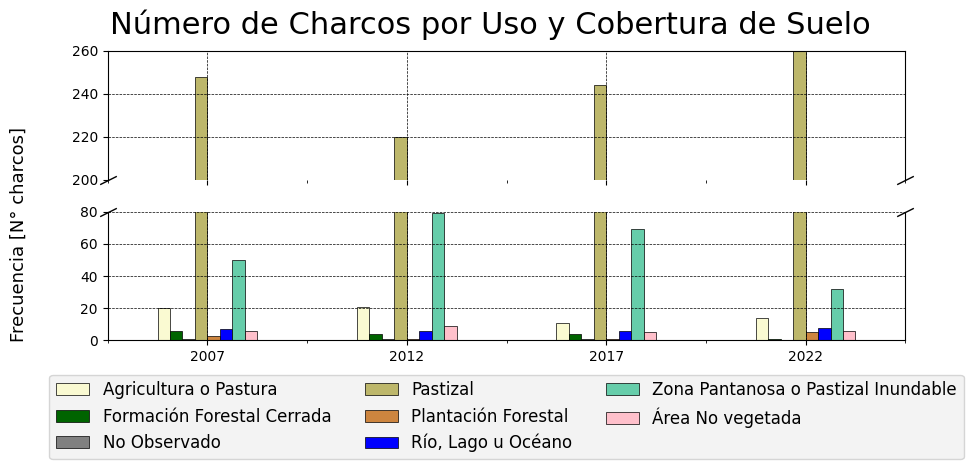

In [18]:
# GRÁFICA DE USOS DE SUELO DE ACUERDO A LOS CHARCOS OCUPADOS Y NO OCUPADOS
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
fig.subplots_adjust(hspace=0.1)

colores = [
          'lightgoldenrodyellow',
          'darkgreen',
          'grey',
          'darkkhaki',
          'peru',
          'blue',
          'mediumaquamarine',
          'pink',
          ]

plt.suptitle("Número de Charcos por Uso y Cobertura de Suelo", y=0.95, fontname='Sans Serif', fontsize=22)

conteo_usos_periodos.transpose().plot.bar(ax=ax1, color=colores, legend=False, edgecolor='black', linewidth=0.5)
conteo_usos_periodos.transpose().plot.bar(ax=ax2, color=colores, legend=False, edgecolor='black', linewidth=0.5)

ax2.set_ylim(0, 80)  # outliers only
ax1.set_ylim(200, 260)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Configurar los ejes mayores de x e y para que estén de color negro
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='both', colors='black')

# Configurar las líneas del grid como punteadas
ax1.grid(which='major', linestyle='dashed', linewidth='0.5', color='black')
ax2.grid(which='major', linestyle='dashed', linewidth='0.5', color='black')

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

new_xtick_labels = ["2007", "2012", "2017", "2022"]
ax2.set_xticklabels(new_xtick_labels, rotation=0, fontname='Sans Serif')

# Leyenda a la derecha
handles, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, prop={'family': 'Sans Serif', 'size': 12})
legend.get_frame().set_facecolor('#f0f0f0')  # Color de fondo de la leyenda

# Cambiar la fuente de las etiquetas de la leyenda a serif
for label in legend.get_texts():
    label.set_fontname('Sans Serif')

fig.supylabel("Frecuencia [N° charcos]", fontname='Sans Serif', size=13, verticalalignment='center')

# Ajustar los márgenes de la figura
plt.tight_layout()

# Guardar la figura como un archivo PDF
plt.savefig("lulc_years_acegua.pdf")

plt.show()

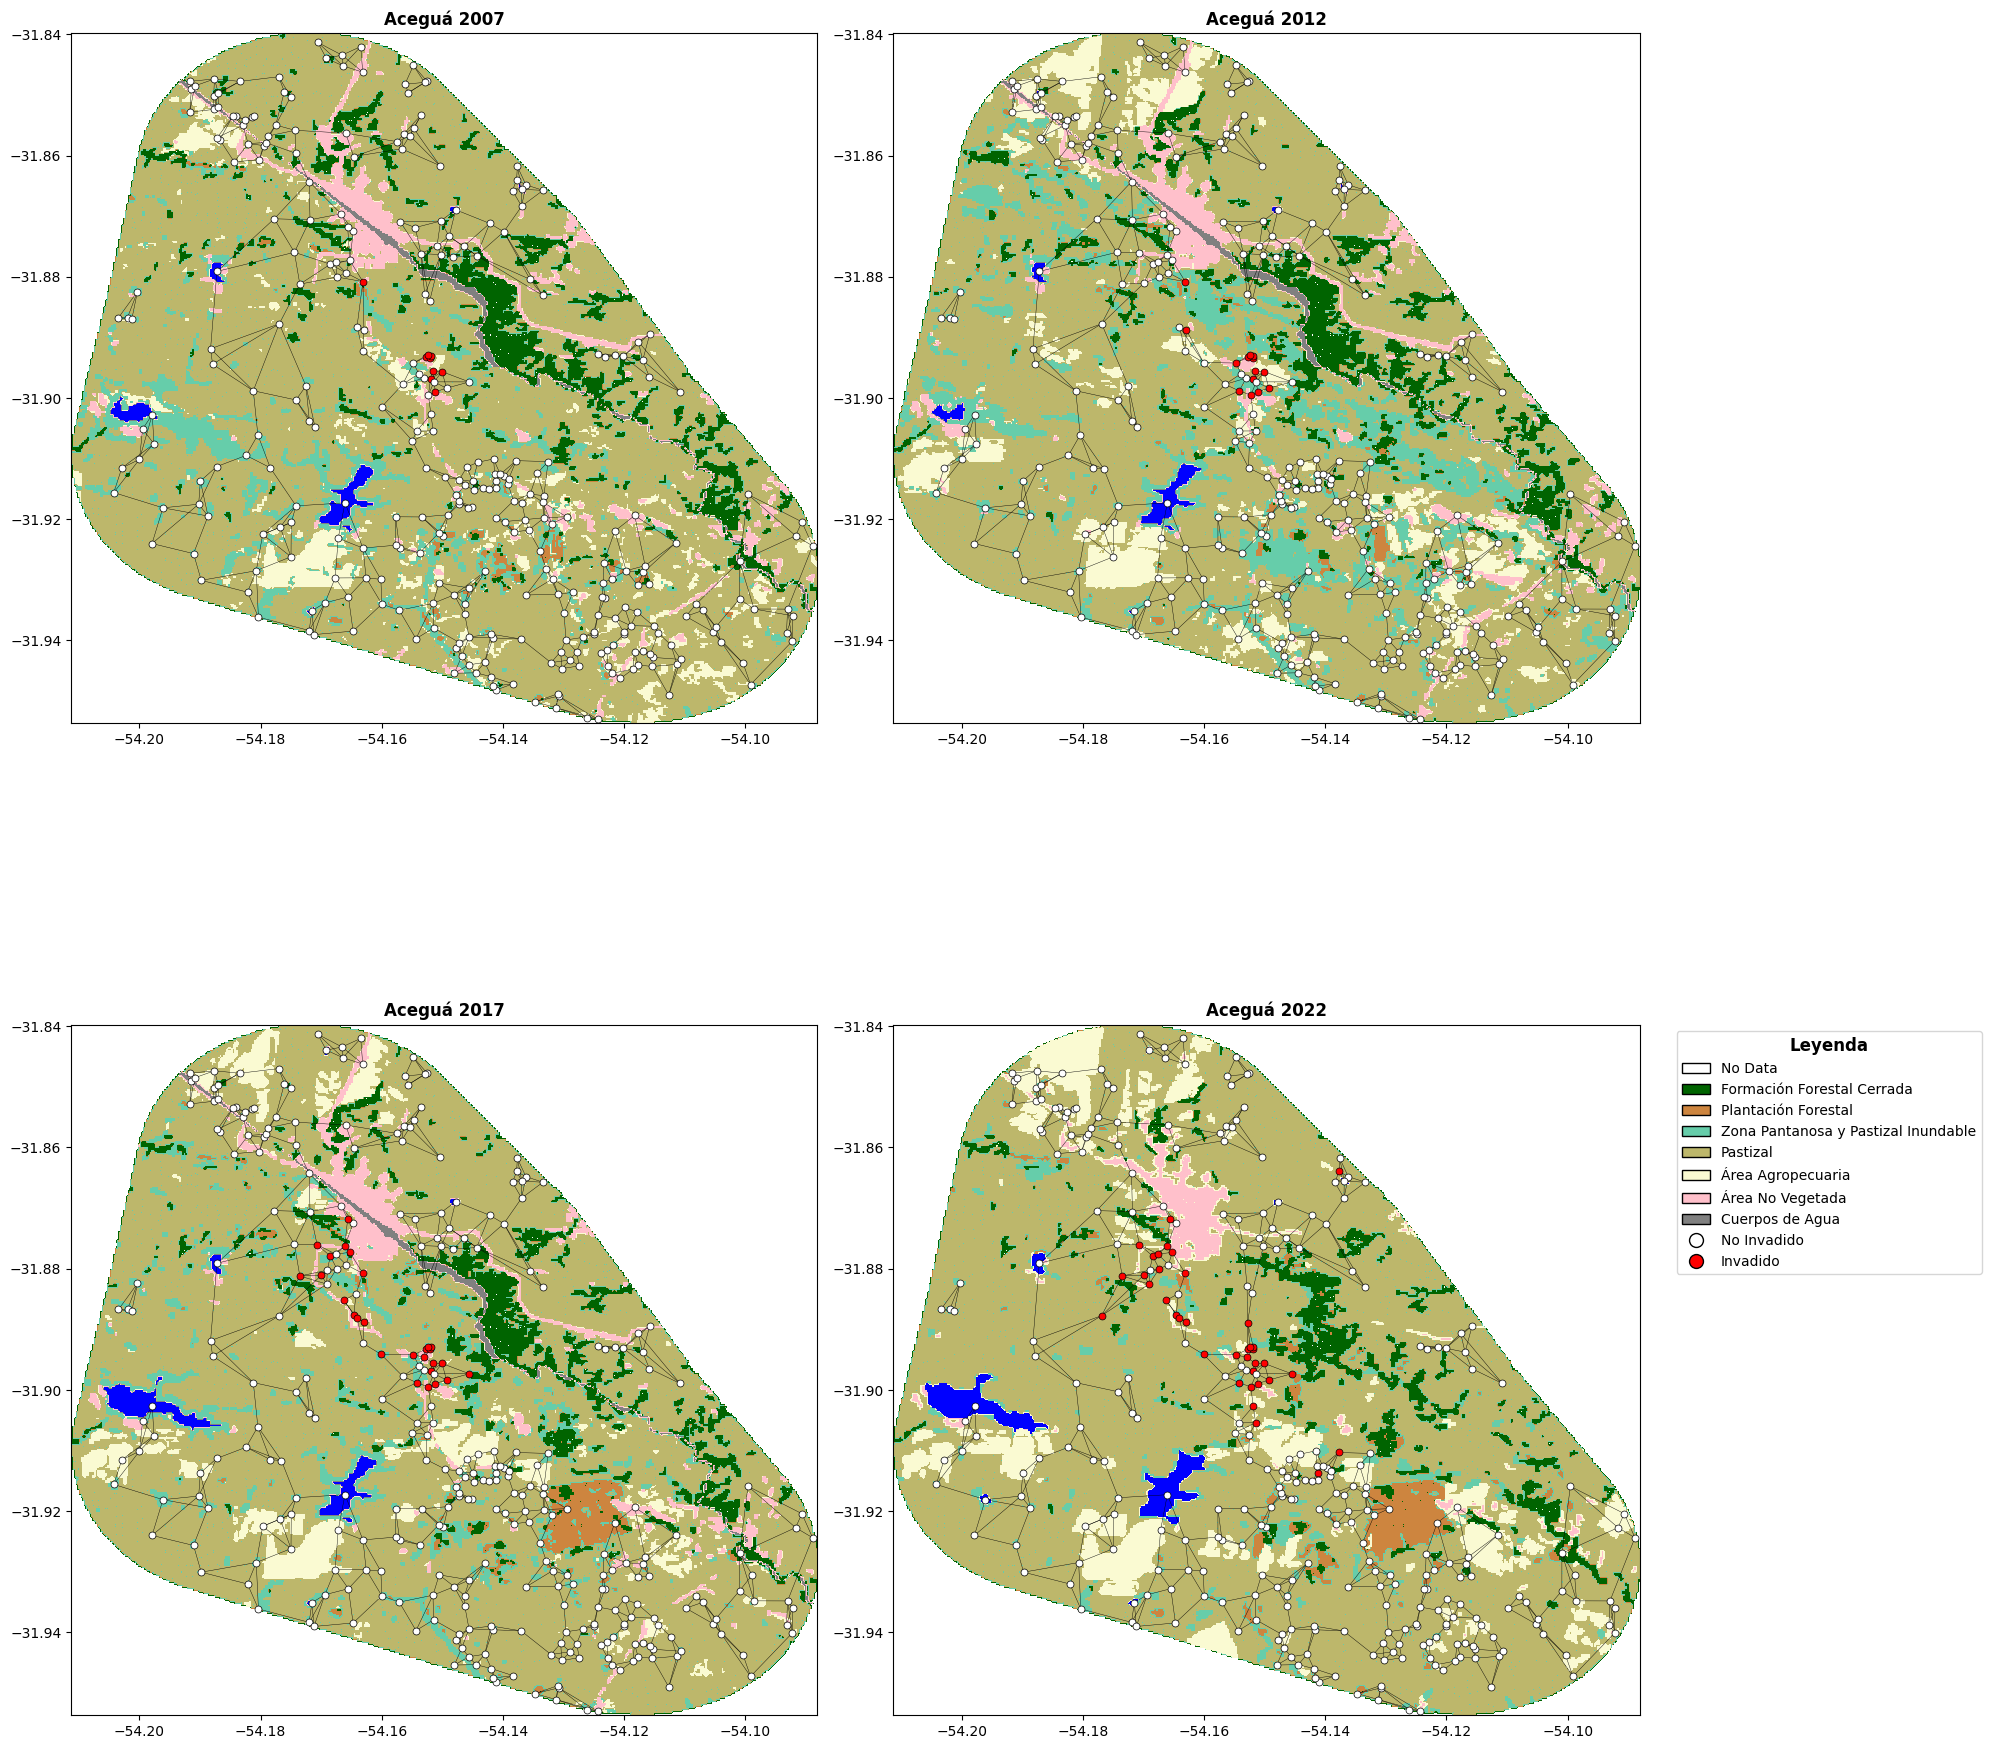

In [20]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, patches
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Definir los niveles y colores para los rasters excepto el del año 2022
levels = [0, 3, 9, 10, 12, 13, 15, 23, 28, 34]
clrs = ['white', 'darkgreen', 'peru', 'mediumaquamarine', 'darkkhaki', 'lightgoldenrodyellow', 'pink', 'grey', 'blue']
cmap, norm = colors.from_levels_and_colors(levels, clrs)

# Definir los niveles y colores para el raster del año 2022 (por cambio de valores)
levels_2022 = [0, 3, 9, 10, 12, 13, 22, 23, 34]
clrs_2022 = ['white', 'darkgreen', 'peru', 'mediumaquamarine', 'darkkhaki', 'lightgoldenrodyellow', 'pink', 'blue']
cmap_2022, norm_2022 = colors.from_levels_and_colors(levels_2022, clrs_2022)

# Lista de archivos raster y shapefiles
files = [
    ("/content/acegua-2007.tif", "/content/Charcos_2007.shp", "Inv_2007", "Aceguá 2007"),
    ("/content/acegua-2012.tif", "/content/Charcos_2012.shp", "Inv_2012", "Aceguá 2012"),
    ("/content/acegua-2017.tif", "/content/Charcos_2017.shp", "Inv_2017", "Aceguá 2017"),
    ("/content/acegua-2022.tif", "/content/Charcos_2022.shp", "Inv_2022", "Aceguá 2022")
]

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for (raster_path, shapefile_path, inv_column, title), ax in zip(files, axes.flatten()):
    # Leer el shapefile
    charcos = gpd.read_file(shapefile_path)

    # Leer el raster
    with rio.open(raster_path) as src:
        img_data = src.read(1)
        transform = src.transform

    # Reproyectar el shapefile al CRS del raster
    charcos = charcos.to_crs(src.crs)

    # Seleccionar el mapa de colores apropiado
    cmap_sel, norm_sel = (cmap_2022, norm_2022) if "2022" in title else (cmap, norm)

    # Graficar el raster
    show(img_data, ax=ax, cmap=cmap_sel, norm=norm_sel, title=title, extent=(transform[2], transform[2] + transform[0] * src.width,
                                                                     transform[5] + transform[4] * src.height, transform[5]))

    # Extraer las coordenadas de los puntos
    coords = np.array(list(charcos.geometry.apply(lambda geom: (geom.x, geom.y))))

    # Aplicar el algoritmo de vecinos más cercanos
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    # Crear el grafo
    G = nx.Graph()
    for i, (dist, index) in enumerate(zip(distances, indices)):
        for j in range(1, len(index)):  # Empezar desde 1 para evitar conectar el punto consigo mismo
            G.add_edge(i, index[j], weight=dist[j])

    # Graficar las conexiones del grafo
    for i, j in G.edges():
        x_coords = [coords[i][0], coords[j][0]]
        y_coords = [coords[i][1], coords[j][1]]
        ax.plot(x_coords, y_coords, color='black', linewidth=0.3, alpha=1)

    # Graficar el shapefile sobre el raster
    for _, row in charcos.iterrows():
        color = 'red' if row[inv_column] == 1 else 'white'
        ax.plot(row.geometry.x, row.geometry.y, marker='o', markersize=5, color=color, linestyle='', markeredgewidth=0.5, markeredgecolor='black')

# Añadir leyenda a la última subplot
class_names = ['No Data', 'Formación Forestal Cerrada', 'Plantación Forestal', 'Zona Pantanosa y Pastizal Inundable',
               'Pastizal', 'Área Agropecuaria', 'Área No Vegetada', 'Cuerpos de Agua']
legend_elements = [patches.Patch(facecolor=clr, edgecolor='k', label=class_name) for clr, class_name in zip(clrs, class_names)]
legend_elements_points = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgewidth=1, markersize=10, label='No Invadido', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgewidth=1, markersize=10, label='Invadido', markeredgecolor='black')
]
legend = axes[-1, -1].legend(handles=legend_elements + legend_elements_points, title='Leyenda',
                             loc='upper left', bbox_to_anchor=(1.04, 1), prop={'size': 10})
plt.setp(legend.get_title(), fontsize=12, fontweight='bold')

plt.tight_layout()

# Guardar la figura como un archivo PDF
plt.savefig("grafos_lulc_acegua.pdf")

plt.show()

Descargar zip con CSV's: https://drive.google.com/file/d/10273qXu5S-9_PoJg8WQQaS7tl0sRUxPd/view?usp=sharing

<ipython-input-21-023f7dcfaae1>:62: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if área:


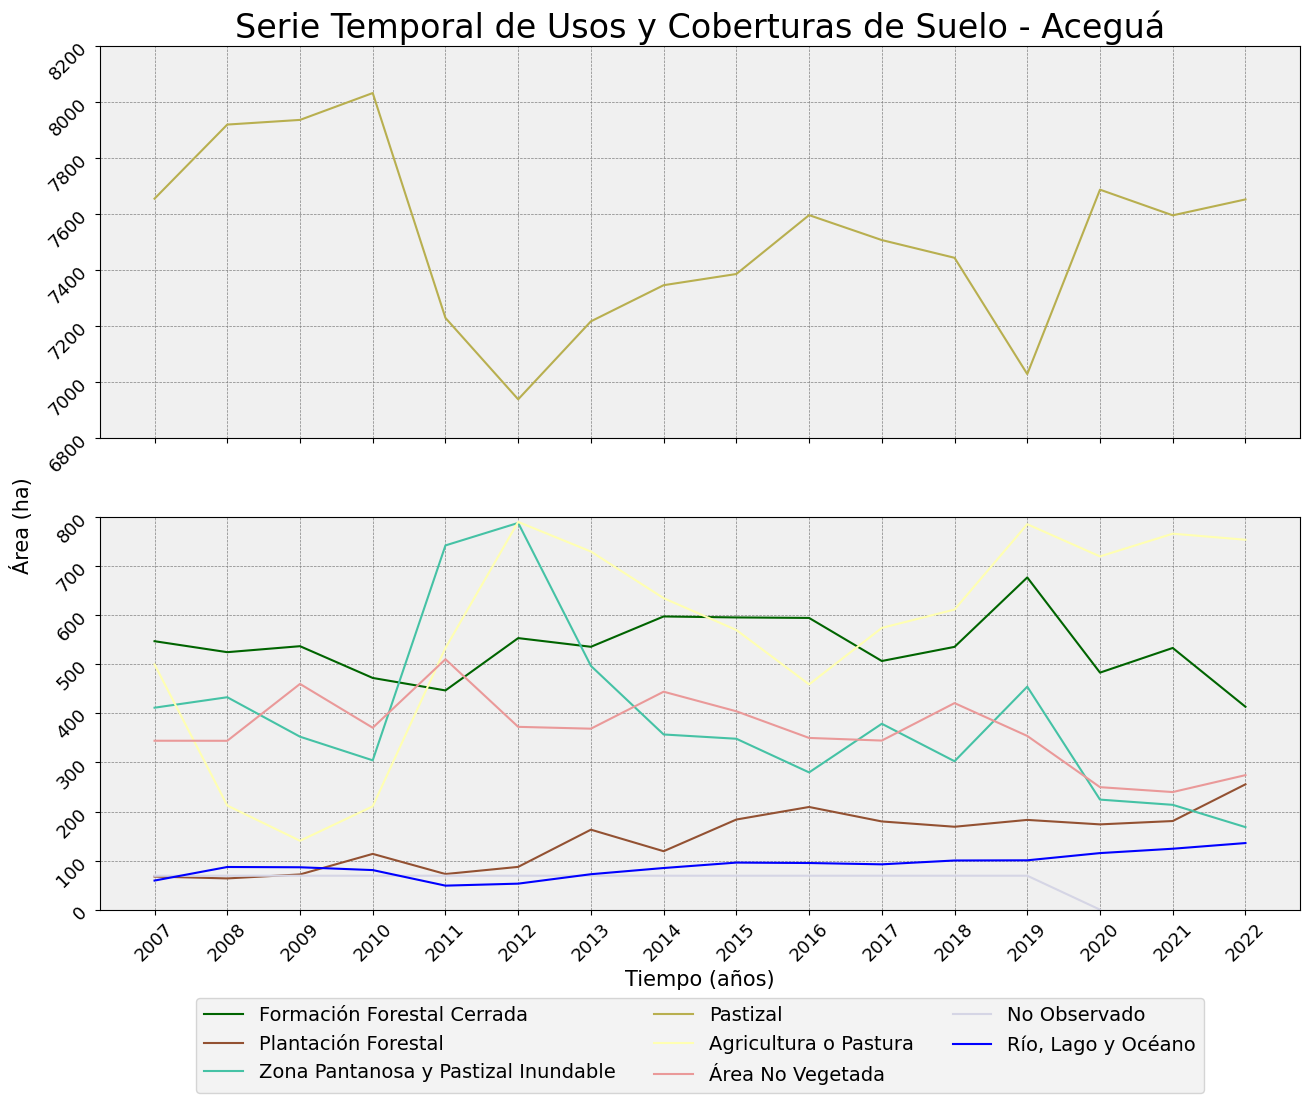

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Directorio donde se encuentran los archivos CSV
directorio = "/content/drive/MyDrive/Agustina_Tesis/MapBiomas/CSV's"

# Lista para almacenar los datos de DN y área por año
datos_por_año = {}

# Obtener la lista de archivos CSV en el directorio
archivos_csv = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.csv')]

# Ordenar los archivos por año
archivos_csv.sort()

# Iterar sobre cada archivo CSV
for archivo in archivos_csv:
    # Extraer el año del nombre del archivo
    año = int(archivo.split('-')[-1][:-4])
    # Leer el archivo CSV como un DataFrame de pandas
    datos = pd.read_csv(os.path.join(directorio, archivo), delimiter=' ')
    # Agregar los datos al diccionario datos_por_año
    datos_por_año[año] = datos

# Definir etiquetas y colores para cada valor de DN
etiquetas_dn = {
    3: 'Formación Forestal Cerrada',
    9: 'Plantación Forestal',
    11: 'Zona Pantanosa y Pastizal Inundable',
    12: 'Pastizal',
    14: 'Agricultura o Pastura',
    22: 'Área No Vegetada',
    27: 'No Observado',
    33: 'Río, Lago y Océano'
}

colores_dn = {
    3: '#006400',   # Formación Forestal Cerrada
    9: '#935132',   # Plantación Forestal
    11: '#45C2A5',  # Zona Pantanosa y Pastizal Inundable
    12: '#B8AF4F',  # Pastizal
    14: '#FFFFB2',  # Agricultura o Pastura
    22: '#EA9999',  # Área No Vegetada
    27: '#D5D5E5',  # No Observado
    33: '#0000FF'   # Río, Lago y Océano
}

# Crear una figura y subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Iterar sobre cada valor DN
for dn in [3, 9, 11, 12, 14, 22, 27, 33]:
    # Listas para almacenar los valores de área para cada año para el valor DN actual
    valores_area = []
    años = []

    # Iterar sobre cada año y obtener el valor de área correspondiente para el valor DN actual
    for año, datos in datos_por_año.items():
        área = datos.loc[datos['DN'] == dn, 'area'].values
        if área:
            valores_area.append(área[0])
            años.append(año)

    # Graficar la serie temporal de área para el valor DN actual con etiquetas y colores personalizados
    ax1.plot(años, valores_area, label=f'{etiquetas_dn[dn]}', color=colores_dn[dn])
    ax2.plot(años, valores_area, label=f'{etiquetas_dn[dn]}', color=colores_dn[dn])

# Configurar título del gráfico
ax1.set_title('Serie Temporal de Usos y Coberturas de Suelo - Aceguá', fontname='Sans Serif', fontsize=24)

# Limitar el eje y para mostrar solo los rangos deseados
ax2.set_ylim(0, 800)
ax1.set_ylim(6800, 8200)

# Eliminar nombre del eje y en el primer subplot
ax1.set_ylabel('')

# Eliminar leyenda del primer subplot (ax1)
ax1.legend().set_visible(False)

# Configurar leyenda para el segundo subplot (ax2) fuera del gráfico
handles, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, prop=FontProperties(family='Sans Serif', size=14))
legend.get_frame().set_facecolor('#f0f0f0')  # Color de fondo de la leyenda

# Añadir grilla punteada en ambos subplots
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax2.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Cambiar el color del fondo a gris claro
ax1.set_facecolor('#f0f0f0')
ax2.set_facecolor('#f0f0f0')

# Ajustar los márgenes de la figura
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.18)

# Agregar nombre del eje y centrado entre ambas figuras
fig.text(0.04, 0.5, 'Área (ha)', fontname='Sans Serif', fontsize=15, va='center', rotation='vertical')

# Añadir etiqueta del eje x
ax2.set_xlabel('Tiempo (años)', fontname='Sans Serif', fontsize=15)

# Mostrar todos los años en el eje x y configurar fuente serif
ax1.set_xticks(list(datos_por_año.keys()))
ax2.set_xticks(list(datos_por_año.keys()))
ax1.tick_params(axis='x', labelsize=13, labelrotation=45)
ax2.tick_params(axis='x', labelsize=13, labelrotation=45)
ax1.tick_params(axis='y', labelsize=13, labelrotation=45)
ax2.tick_params(axis='y', labelsize=13, labelrotation=45)
for ax in [ax1, ax2]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Sans Serif')

# Guardar la figura como un archivo PDF
plt.savefig("serie_temporal.pdf")

# Mostrar el gráfico
plt.show()